In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, precision_recall_curve,
    average_precision_score, log_loss
)
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split

rng = np.random.RandomState(42)

In [2]:
# ---------- Data Generation ----------
"""
**Dataset:** Binary Classification (2 Features)
- Generates separable clusters for logistic regression.
- Split into 70% train / 30% test.
"""
X_bin, y_bin = make_classification(
    n_samples=800,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    class_sep=1.5,
    flip_y=0.03,
    random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(
    X_bin, y_bin, test_size=0.3, random_state=42, stratify=y_bin
)

In [3]:
# Pipeline with scaling + logistic regression
logreg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, solver="lbfgs"))
logreg.fit(X_train, y_train)
probs_test = logreg.predict_proba(X_test)[:, 1]

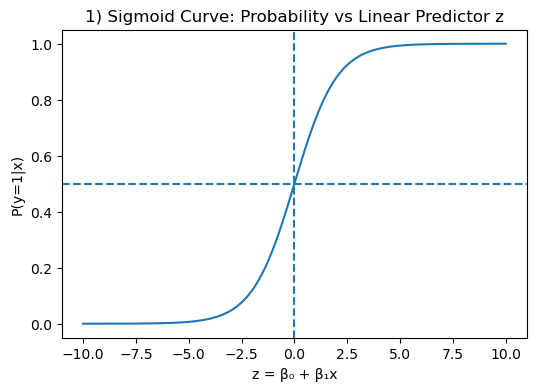

In [4]:
# ---------- 1) Sigmoid Curve ----------
"""
**Plot name:** Sigmoid Curve – Probability vs Linear Predictor
- **X-axis:** z = β₀ + β₁x
- **Y-axis:** P(y=1|x)
- **When useful:** Visualize logistic (sigmoid) mapping from linear space to probability space.
- **Conditions/Caveats:** Shows how small linear changes near z=0 produce large probability shifts.
"""
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.linspace(-10, 10, 400)
p = sigmoid(z)

plt.figure(figsize=(6,4))
plt.plot(z, p)
plt.axhline(0.5, linestyle="--")
plt.axvline(0.0, linestyle="--")
plt.title("1) Sigmoid Curve: Probability vs Linear Predictor z")
plt.xlabel("z = β₀ + β₁x")
plt.ylabel("P(y=1|x)")
plt.show()

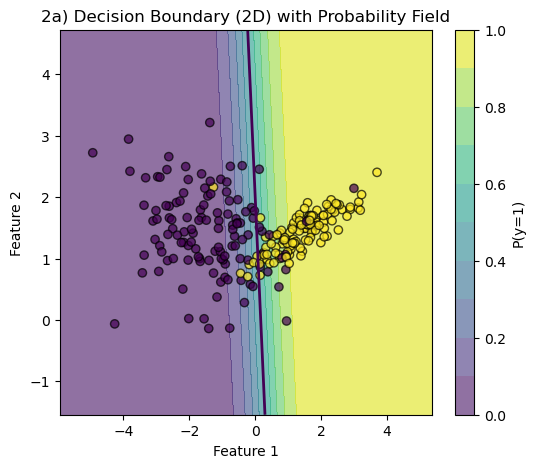

In [5]:
# ---------- 2a) Decision Boundary (2D) with Probability Field ----------
"""
**Plot name:** Decision Boundary (2D) with Probability Field
- **X-axis:** Feature 1
- **Y-axis:** Feature 2
- **When useful:** Visualize model’s decision regions and probability contours in feature space.
- **Conditions/Caveats:** Works only with 2D features; visual aid for separation confidence.
"""
x_min, x_max = X_bin[:, 0].min() - 1, X_bin[:, 0].max() + 1
y_min, y_max = X_bin[:, 1].min() - 1, X_bin[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
probs_grid = logreg.predict_proba(grid)[:, 1].reshape(xx.shape)

plt.figure(figsize=(6,5))
cs = plt.contourf(xx, yy, probs_grid, levels=np.linspace(0, 1, 11), alpha=0.6)
plt.colorbar(cs, label="P(y=1)")
plt.contour(xx, yy, probs_grid, levels=[0.5], linewidths=2)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, edgecolor="k", alpha=0.7)
plt.title("2a) Decision Boundary (2D) with Probability Field")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


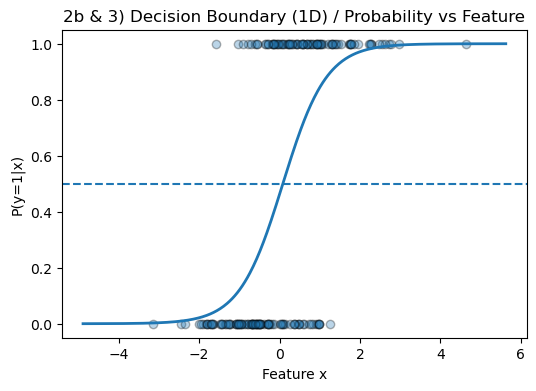

In [6]:
# ---------- 2b & 3) Decision Boundary (1D) / Probability vs Feature ----------
"""
**Plot name:** Decision Boundary (1D)
- **X-axis:** Feature x
- **Y-axis:** P(y=1|x)
- **When useful:** Demonstrates logistic curve fitting in 1D, showing threshold and probability mapping.
- **Conditions/Caveats:** Ideal to show transition near P=0.5 where class decision flips.
"""
X1 = rng.normal(0, 1.2, size=(600, 1))
true_beta0, true_beta1 = -0.3, 2.0
p_true = sigmoid(true_beta0 + true_beta1 * X1.ravel())
y1 = (rng.rand(600) < p_true).astype(int)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42, stratify=y1)
logreg1D = make_pipeline(StandardScaler(), LogisticRegression(max_iter=4000, solver="lbfgs"))
logreg1D.fit(X1_train, y1_train)

xs = np.linspace(X1.min()-1, X1.max()+1, 500).reshape(-1, 1)
ps = logreg1D.predict_proba(xs)[:, 1]

plt.figure(figsize=(6,4))
plt.scatter(X1_test, y1_test, alpha=0.3, edgecolor="k")
plt.plot(xs, ps, linewidth=2)
plt.axhline(0.5, linestyle="--")
plt.title("2b & 3) Decision Boundary (1D) / Probability vs Feature")
plt.xlabel("Feature x")
plt.ylabel("P(y=1|x)")
plt.show()


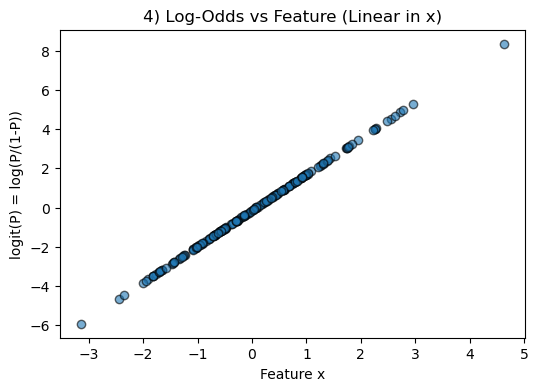

In [7]:
# ---------- 4) Log-Odds vs Feature ----------
"""
**Plot name:** Log-Odds (Linear) vs Feature
- **X-axis:** Feature x
- **Y-axis:** logit(P) = log(P/(1-P))
- **When useful:** Verify that the log-odds are linear in predictors, a key logistic regression assumption.
- **Conditions/Caveats:** Should appear linear; deviations suggest model misspecification.
"""
eps = 1e-12
ps_test_1d = logreg1D.predict_proba(X1_test)[:, 1]
logits_1d = np.log(np.clip(ps_test_1d, eps, 1-eps) / np.clip(1-ps_test_1d, eps, 1-eps))

plt.figure(figsize=(6,4))
plt.scatter(X1_test.ravel(), logits_1d, alpha=0.6, edgecolor="k")
plt.title("4) Log-Odds vs Feature (Linear in x)")
plt.xlabel("Feature x")
plt.ylabel("logit(P) = log(P/(1-P))")
plt.show()

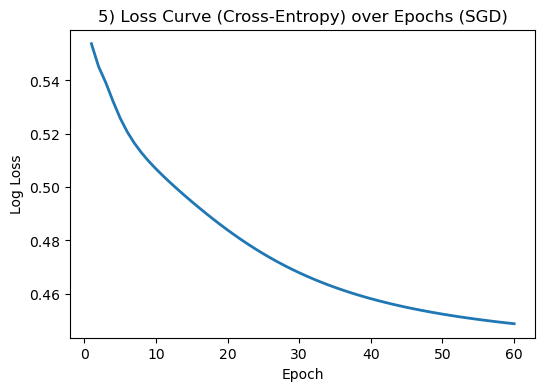

In [8]:
# ---------- 5) Loss Curve (Cross-Entropy) ----------
"""
**Plot name:** Loss Curve (Cross-Entropy)
- **X-axis:** Epoch
- **Y-axis:** Log Loss
- **When useful:** Observe optimization progress; confirm convex convergence behavior.
- **Conditions/Caveats:** Should decrease smoothly; plateaus or spikes indicate learning rate issues.
"""
scaler = StandardScaler()
X1_train_s = scaler.fit_transform(X1_train)
sgd = SGDClassifier(loss="log_loss", max_iter=1, learning_rate="optimal", tol=None, random_state=42)
classes = np.unique(y1_train)
losses = []
for epoch in range(60):
    sgd.partial_fit(X1_train_s, y1_train, classes=classes)
    z = X1_train_s @ sgd.coef_.T + sgd.intercept_
    pe = 1.0 / (1.0 + np.exp(-z))
    pe = pe.ravel()
    losses.append(log_loss(y1_train, np.clip(pe, 1e-12, 1-1e-12)))

plt.figure(figsize=(6,4))
plt.plot(range(1, len(losses)+1), losses, linewidth=2)
plt.title("5) Loss Curve (Cross-Entropy) over Epochs (SGD)")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.show()

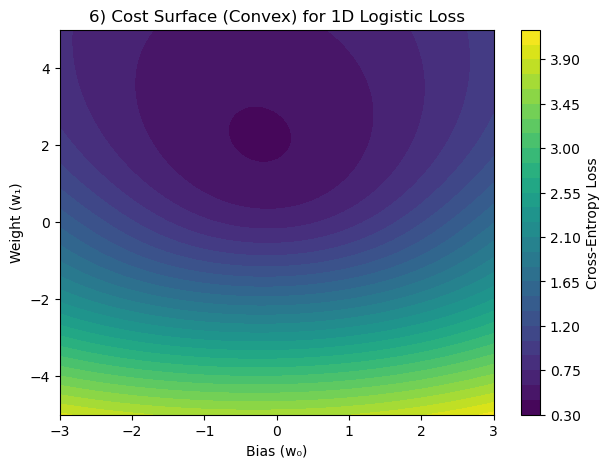

In [9]:
# ---------- 6) Cost Surface (Convex) for 1D Logistic Loss ----------
"""
**Plot name:** Cost Surface (Convex)
- **X-axis:** Bias term (w₀)
- **Y-axis:** Weight term (w₁)
- **Z-axis (color):** Cross-entropy loss value
- **When useful:** Demonstrate convexity of logistic loss and presence of a single global minimum.
"""
W0 = np.linspace(-3, 3, 100)
W1 = np.linspace(-5, 5, 120)
W0g, W1g = np.meshgrid(W0, W1)

X1_train_s = X1_train_s.ravel()
Ygrid = y1_train

def loss_at(w0, w1):
    z = w0 + w1 * X1_train_s
    p = 1.0 / (1.0 + np.exp(-z))
    p = np.clip(p, 1e-12, 1-1e-12)
    return -np.mean(Ygrid * np.log(p) + (1 - Ygrid) * np.log(1 - p))

Zloss = np.zeros_like(W0g)
for i in range(W0g.shape[0]):
    for j in range(W0g.shape[1]):
        Zloss[i, j] = loss_at(W0g[i, j], W1g[i, j])

plt.figure(figsize=(7,5))
cs = plt.contourf(W0g, W1g, Zloss, levels=30)
plt.colorbar(cs, label="Cross-Entropy Loss")
plt.title("6) Cost Surface (Convex) for 1D Logistic Loss")
plt.xlabel("Bias (w₀)")
plt.ylabel("Weight (w₁)")
plt.show()

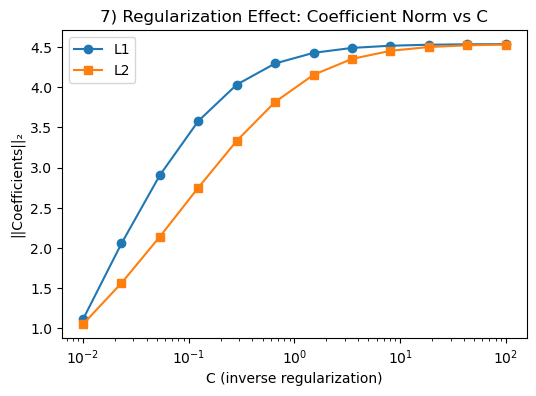

In [10]:
# ---------- 7) Regularization Effect (L1 vs L2) ----------
"""
**Plot name:** Regularization Effect (Coefficient Norm vs C)
- **X-axis:** C (inverse of regularization strength)
- **Y-axis:** ||Coefficients||₂
- **When useful:** Compare effect of L1 and L2 penalties on coefficient shrinkage.
- **Conditions/Caveats:** L1 drives sparsity; L2 distributes shrinkage smoothly.
"""
Cs = np.logspace(-2, 2, 12)
coef_L1, coef_L2 = [], []
for C in Cs:
    lr_l1 = make_pipeline(StandardScaler(), LogisticRegression(penalty="l1", solver="liblinear", C=C, max_iter=5000))
    lr_l2 = make_pipeline(StandardScaler(), LogisticRegression(penalty="l2", solver="liblinear", C=C, max_iter=5000))
    lr_l1.fit(X_train, y_train)
    lr_l2.fit(X_train, y_train)
    coef_L1.append(np.linalg.norm(lr_l1.named_steps["logisticregression"].coef_))
    coef_L2.append(np.linalg.norm(lr_l2.named_steps["logisticregression"].coef_))

plt.figure(figsize=(6,4))
plt.plot(Cs, coef_L1, marker="o", label="L1")
plt.plot(Cs, coef_L2, marker="s", label="L2")
plt.xscale("log")
plt.title("7) Regularization Effect: Coefficient Norm vs C")
plt.xlabel("C (inverse regularization)")
plt.ylabel("||Coefficients||₂")
plt.legend()
plt.show()

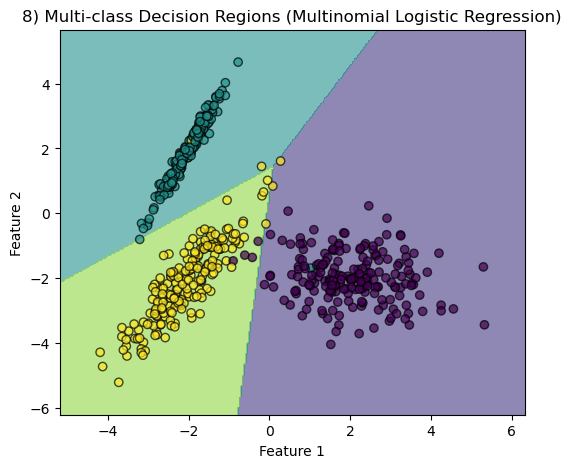

In [11]:
# ---------- 8) Multi-class Decision Regions ----------
"""
**Plot name:** Multi-class Decision Regions (Softmax)
- **X-axis:** Feature 1
- **Y-axis:** Feature 2
- **When useful:** Visualize boundaries between classes in a multinomial logistic model.
- **Conditions/Caveats:** Only feasible in 2D; boundaries show class dominance zones.
"""
X_mc, y_mc = make_classification(
    n_samples=600, n_features=2, n_redundant=0, n_informative=2,
    n_clusters_per_class=1, n_classes=3, class_sep=2.0, random_state=7
)
multi = make_pipeline(StandardScaler(), LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=5000))
multi.fit(X_mc, y_mc)

x_min, x_max = X_mc[:, 0].min() - 1, X_mc[:, 0].max() + 1
y_min, y_max = X_mc[:, 1].min() - 1, X_mc[:, 1].max() + 1
xxm, yym = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
Z = multi.predict(np.c_[xxm.ravel(), yym.ravel()]).reshape(xxm.shape)

plt.figure(figsize=(6,5))
plt.contourf(xxm, yym, Z, levels=np.arange(0, 4)-0.5, alpha=0.6)
plt.scatter(X_mc[:,0], X_mc[:,1], c=y_mc, edgecolor="k", alpha=0.7)
plt.title("8) Multi-class Decision Regions (Multinomial Logistic Regression)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

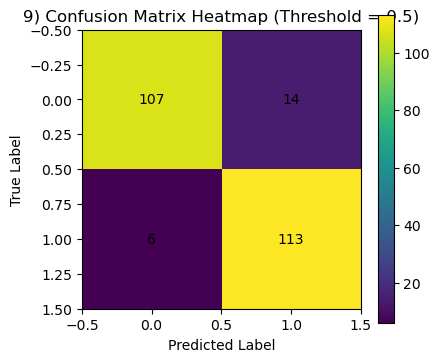

In [17]:
# ---------- 9) Confusion Matrix Heatmap ----------
"""
**Plot name:** Confusion Matrix (Threshold = 0.5)
- **X-axis:** Predicted Label
- **Y-axis:** True Label
- **When useful:** Evaluate classification accuracy and class-specific errors.
- **Conditions/Caveats:** Use adjusted thresholds for imbalanced data.
"""
y_pred = (probs_test >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4.5,4))
plt.imshow(cm, interpolation="nearest")
plt.title("9) Confusion Matrix Heatmap (Threshold = 0.5)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.colorbar()
plt.show()

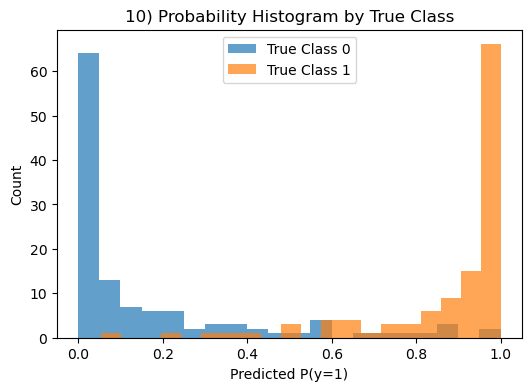

In [18]:
# ---------- 10) Probability Histogram by True Class ----------
"""
**Plot name:** Probability Histogram by True Class
- **X-axis:** Predicted P(y=1)
- **Y-axis:** Count
- **When useful:** Shows class separation in predicted probabilities.
- **Conditions/Caveats:** Overlap indicates uncertainty or weak separation.
"""
plt.figure(figsize=(6,4))
plt.hist(probs_test[y_test==0], bins=20, alpha=0.7, label="True Class 0")
plt.hist(probs_test[y_test==1], bins=20, alpha=0.7, label="True Class 1")
plt.title("10) Probability Histogram by True Class")
plt.xlabel("Predicted P(y=1)")
plt.ylabel("Count")
plt.legend()
plt.show()

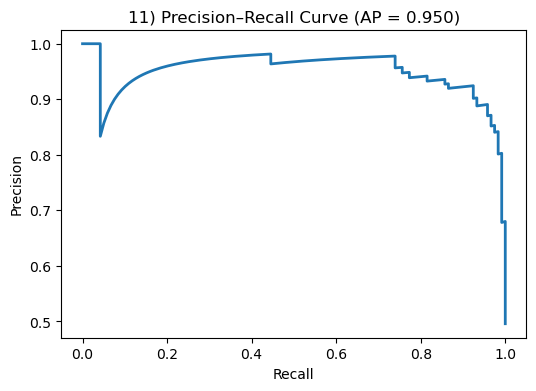

In [19]:
# ---------- 11) Precision–Recall Curve ----------
"""
**Plot name:** Precision–Recall Curve
- **X-axis:** Recall
- **Y-axis:** Precision
- **When useful:** Evaluate model performance on imbalanced data.
- **Conditions/Caveats:** Area under curve (AP) summarizes tradeoff; focus on high recall regions.
"""
prec, rec, thr = precision_recall_curve(y_test, probs_test)
ap = average_precision_score(y_test, probs_test)

plt.figure(figsize=(6,4))
plt.plot(rec, prec, linewidth=2)
plt.title(f"11) Precision–Recall Curve (AP = {ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

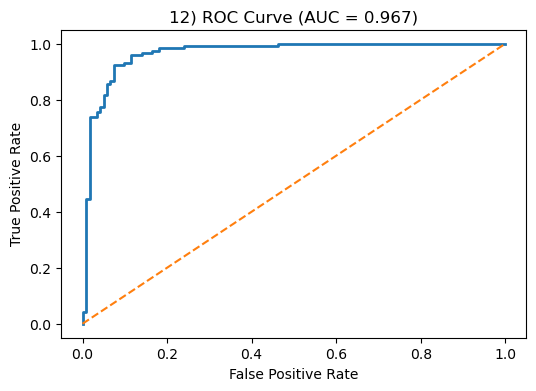

In [20]:
# ---------- 12) ROC Curve ----------
"""
**Plot name:** ROC Curve (Receiver Operating Characteristic)
- **X-axis:** False Positive Rate
- **Y-axis:** True Positive Rate
- **When useful:** Measure model’s ability to separate classes across thresholds.
- **Conditions/Caveats:** AUC closer to 1.0 indicates strong separability.
"""
fpr, tpr, thr_roc = roc_curve(y_test, probs_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], linestyle="--")
plt.title(f"12) ROC Curve (AUC = {roc_auc:.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

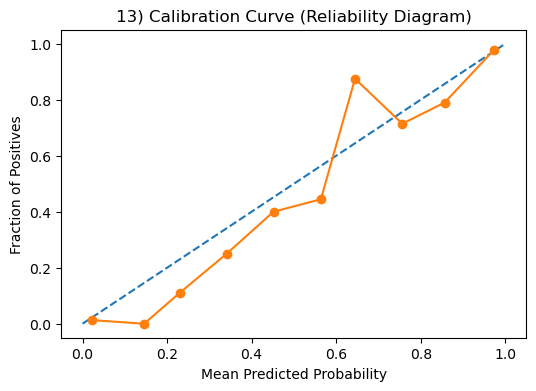

In [21]:
# ---------- 13) Calibration / Reliability Diagram ----------
"""
**Plot name:** Calibration Curve (Reliability Diagram)
- **X-axis:** Mean Predicted Probability
- **Y-axis:** Fraction of Positives
- **When useful:** Check probability calibration—do predicted probabilities reflect true likelihood?
- **Conditions/Caveats:** Perfect calibration lies on diagonal y=x line.
"""
frac_pos, mean_pred = calibration_curve(y_test, probs_test, n_bins=10, strategy="uniform")

plt.figure(figsize=(6,4))
plt.plot([0,1],[0,1], linestyle="--")
plt.plot(mean_pred, frac_pos, marker="o")
plt.title("13) Calibration Curve (Reliability Diagram)")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.show()